## Overview

[TensorFlow Lite](https://www.tensorflow.org/lite/) now supports converting activations to 16-bit integer values and weights to 8-bit integer values during model conversion from TensorFlow to TensorFlow Lite's flat buffer format. We refer to this mode as the "16x8 quantization mode". This mode can improve accuracy of the quantized model significantly, when activations are sensitive to the quantization, while still achieving almost 3-4x reduction in model size. Moreover, this fully quantized model can be consumed by integer-only hardware accelerators.



Some examples of models that benefit from this mode of the post-training quantization include:

* super-resolution,
* audio signal processing such as noise cancelling and beamforming,
* image de-noising,
* HDR reconstruction from a single image

In this tutorial, you train an MNIST model from scratch, check its accuracy in TensorFlow, and then convert the model into a Tensorflow Lite flatbuffer using this mode. At the end you check the accuracy of the converted model and compare it to the original float32 model. Note that this example demonstrates the usage of this mode and doesn't show benefits over other available quantization techniques in TensorFlow Lite.

## Build an MNIST model

### Setup

In [2]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib




Check that the 16x8 quantization mode is available


In [3]:
tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8

<OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8: 'EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8'>

## Train and export the model

In [4]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_data=(test_images, test_labels)
)


1875/1875 [==============================] - 10s 3ms/step - loss: 0.2772 - accuracy: 0.9218 - val_loss: 0.1344 - val_accuracy: 0.9619


For the example, you trained the model for just a single epoch, so it only trains to ~96% accuracy.

## Convert to a TensorFlow Lite model
Using the TensorFlow Lite Converter, you can now convert the trained model into a TensorFlow Lite model.

Now, convert the model using TFliteConverter into default float32 format:

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

2023-10-17 23:04:42.796076: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/sraj/tmpi_2szbt8/assets


2023-10-17 23:04:45.602348: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-10-17 23:04:45.602419: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


Write it out to a `.tflite` file:



In [6]:
tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [7]:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

84500

To instead quantize the model to 16x8 `quantization` mode, first set the optimizations flag to use default optimizations. Then specify that 16x8 quantization mode is the required supported operation in the target specification:



In [8]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]

As in the case of int8 post-training quantization, it is possible to produce a fully integer quantized model by setting converter options `inference_input(output)_type` to tf.int16.

Set the calibration data:



In [9]:
mnist_train, _ = tf.keras.datasets.mnist.load_data()
images = tf.cast(mnist_train[0], tf.float32) / 255.0
mnist_ds = tf.data.Dataset.from_tensor_slices((images)).batch(1)
def representative_data_gen():
  for input_value in mnist_ds.take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]
converter.representative_dataset = representative_data_gen

Finally, convert the model as usual. Note, by default the converted model will still use float input and outputs for invocation convenience.



In [10]:
tflite_16x8_model = converter.convert()
tflite_model_16x8_file = tflite_models_dir/"mnist_model_quant_16x8.tflite"
tflite_model_16x8_file.write_bytes(tflite_16x8_model)

INFO:tensorflow:Assets written to: /tmp/sraj/tmp6b7tsc2k/assets


INFO:tensorflow:Assets written to: /tmp/sraj/tmp6b7tsc2k/assets
2023-10-17 23:07:51.567779: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-10-17 23:07:51.568371: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


24640

Note how the resulting file is approximately `1/3` the size.



In [11]:
ls -lh {tflite_models_dir}


total 136K
-rw-r--r--. 1 sraj zh 25K Oct 17 23:07 mnist_model_quant_16x8.tflite
-rw-r--r--. 1 sraj zh 24K Oct 14 09:12 mnist_model_quant.tflite
-rw-r--r--. 1 sraj zh 83K Oct 17 23:05 mnist_model.tflite


# Run the TensorFlow Lite models
Run the TensorFlow Lite model using the Python TensorFlow Lite Interpreter.

### Load the model into the interpreters

In [12]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [13]:
interpreter_16x8 = tf.lite.Interpreter(model_path=str(tflite_model_16x8_file))
interpreter_16x8.allocate_tensors()

# Test the models on one image

In [14]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

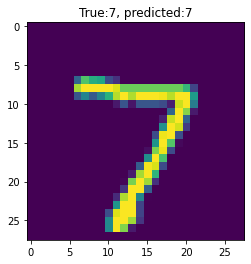

In [15]:
import matplotlib.pylab as plt

plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

In [16]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter_16x8.get_input_details()[0]["index"]
output_index = interpreter_16x8.get_output_details()[0]["index"]

interpreter_16x8.set_tensor(input_index, test_image)
interpreter_16x8.invoke()
predictions = interpreter_16x8.get_tensor(output_index)

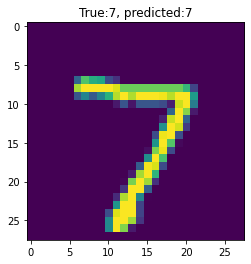

In [18]:
plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

### Evaluate the models

In [19]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [20]:
print(evaluate_model(interpreter))

0.9619


Repeat the evaluation on the 16x8 quantized model:



In [21]:
# NOTE: This quantization mode is an experimental post-training mode,
# it does not have any optimized kernels implementations or
# specialized machine learning hardware accelerators. Therefore,
# it could be slower than the float interpreter.
print(evaluate_model(interpreter_16x8))

0.9618


In this example, you have quantized a model to 16x8 with no difference in the accuracy, but with the 3x reduced size.



Another a few different quantizations are:
1. https://www.tensorflow.org/lite/performance/quantization_spec
2. https://www.tensorflow.org/lite/performance/quantization_debugger